### Final Project Approach

Create a library of short moves: fwd, +left, +right

Obstacle detection, go in minimum trine

In [6]:
# Code adapted from: https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/autonomousSequence.py

import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# CrazyFlie imports:

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger
from cflib.positioning.position_hl_commander import PositionHlCommander


### Bounding Box 

In [35]:
class Box:
    def __init__(self, x, y, yaw=0, length=2.54, width=2.28):
        self.origin = (x, y)
        self.length = length
        self.width = width
        self.starting_yaw = yaw
        self.path = [(x, y)]
        # Calculate the x and y of the goal
        
        # Convert yaw from degrees to radians for trigonometric calculations
        yaw_rad = np.radians(yaw)
        # ----- getting goal -----
        goal_x = x + length * np.cos(yaw_rad)
        goal_y = y + length * np.sin(yaw_rad)
        goal = (goal_x, goal_y)
        self.goal = goal

        # ----- get prime bookfinding position -----
        self.prime = (goal_x + 0.4, goal_y)
        
        # ----- get left wall -----
        left_yaw_rad = yaw_rad - np.pi / 2  # Subtract 90 degrees to get the left direction
        
        # Calculate the points for the left wall
        # The first point is near the origin
        left_wall_x1 = x + width/2 * np.cos(left_yaw_rad)
        left_wall_y1 = y + width/2 * np.sin(left_yaw_rad)

        # The second point is near the goal
        left_wall_x2 = goal[0] + width/2 * np.cos(left_yaw_rad)
        left_wall_y2 = goal[1] + width/2 * np.sin(left_yaw_rad)
        self.left_wall = [(left_wall_x1, left_wall_y1), (left_wall_x2, left_wall_y2)]
        
        # ----- get right wall -----
        right_yaw_rad = yaw_rad + np.pi / 2

        # Calculate the points for the right wall
        # The first point is near the origin
        right_wall_x1 = x + width/2 * np.cos(right_yaw_rad)
        right_wall_y1 = y + width/2 * np.sin(right_yaw_rad)

        # The second point is near the goal
        right_wall_x2 = goal[0] + width/2 * np.cos(right_yaw_rad)
        right_wall_y2 = goal[1] + width/2 * np.sin(right_yaw_rad)
        self.right_wall = [(right_wall_x1, right_wall_y1), (right_wall_x2, right_wall_y2)]

        
    def get_distance_between_walls(self, x, y):
        # Return a value between -1 and 1 that represents distance between the walls
        # -1 means the drone is on the left wall, 1 means the drone is on the right wall
        # Calculate the shortest distance from the point to the left and right walls
        left_wall_distance = np.abs((self.left_wall[1][1] - self.left_wall[0][1]) * x - (self.left_wall[1][0] - self.left_wall[0][0]) * y + self.left_wall[1][0] * self.left_wall[0][1] - self.left_wall[1][1] * self.left_wall[0][0]) / np.sqrt((self.left_wall[1][1] - self.left_wall[0][1])**2 + (self.left_wall[1][0] - self.left_wall[0][0])**2)
        right_wall_distance = np.abs((self.right_wall[1][1] - self.right_wall[0][1]) * x - (self.right_wall[1][0] - self.right_wall[0][0]) * y + self.right_wall[1][0] * self.right_wall[0][1] - self.right_wall[1][1] * self.right_wall[0][0]) / np.sqrt((self.right_wall[1][1] - self.right_wall[0][1])**2 + (self.right_wall[1][0] - self.right_wall[0][0])**2)
        
        normalized_distance = (right_wall_distance - left_wall_distance) / left_wall_distance + right_wall_distance
        return normalized_distance
    
    def show_pos(self, x, y):
        # Plot the position of the drone within the box, as well as the origin and goal
        if self.path[-1][0] != x or self.path[-1][1] != y:
            self.path.append((x, y))
        # Plot the path
        print(self.path)
        plt.plot(*zip(*self.path), 'p-')
        plt.plot(x, y, 'ro')
        plt.plot(self.origin[0], self.origin[1], 'bo')
        plt.plot(self.goal[0], self.goal[1], 'go')
        plt.plot([self.origin[0], self.goal[0]], [self.origin[1], self.goal[1]], 'g--')
        plt.plot([self.left_wall[0][0], self.left_wall[1][0]], [self.left_wall[0][1], self.left_wall[1][1]], 'b--')
        plt.plot([self.right_wall[0][0], self.right_wall[1][0]], [self.right_wall[0][1], self.right_wall[1][1]], 'b--')
        plt.axis('equal')
        plt.show()


### Determine direction of least obstacles

In [3]:

def smart_which_way(left_fov, middle_fov, right_fov, x, y, box):
    # alpha = how much to favor going forward (>1)
    alpha = 1.2
    # beta = how much to punish going towards near wall (<1)
    beta = 0.6

    area = middle_fov.shape[0]*middle_fov.shape[1]
    left_score = area - np.count_nonzero(left_fov)
    middle_score = area - np.count_nonzero(middle_fov)
    right_score = area - np.count_nonzero(right_fov)
    print(f'SCORE0: [{left_score}, {middle_score}, {right_score}]')
    
    middle_score *= alpha

    # Punish going towards the near wall
    dist = box.get_distance_between_walls(x, y)
    if dist < -0.75:
        left_score *= beta**2
    elif dist > 0.75:
        right_score *= beta**2
    elif dist < -0.3:
        left_score *= beta
    elif dist > 0.3:
        right_score *= beta
    
    print(f'RESULT: [{left_score}, {middle_score}, {right_score}]')
    if middle_score >= right_score and middle_score >= left_score:
        return 'forward'
    elif right_score > left_score and right_score > middle_score:
        return 'right'
    else:
        return 'left'

def which_way_book(mask):
    height, width = mask.shape
    left_mask = mask[:, :width//3]
    middle_mask = mask[:, width//3:2*width//3]
    right_mask = mask[:, 2*width//3:]

    left_pixels = np.count_nonzero(left_mask)
    middle_pixels = np.count_nonzero(middle_mask)
    right_pixels = np.count_nonzero(right_mask)

    # if the left pixels is within 20% of right pixels, then we're centered
    if abs(left_pixels - right_pixels) <= 0.2 * right_pixels and middle_pixels > left_pixels and middle_pixels > right_pixels:
        # if the middle is 90 % full
        if middle_pixels / (width * height / 3) > 0.9:
            return 'land forward'
        else:
            return 'scoot forward'
    elif left_pixels < right_pixels:
        return 'scoot right'
    else:
        return 'scoot left'


### Movement

In [33]:
def move_forward_and_right(cf, current_x, current_y, duration=8):
    dx, dy = 0.2, -0.2
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.5)
        time.sleep(0.1)
    return current_x + dx*0.75, current_y + dy * 1.0

def move_forward_and_left(cf, current_x, current_y, duration=8):
    dx, dy = 0.2, 0.2
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.5)
        time.sleep(0.1)
    return current_x + dx*0.75, current_y + dy * 1.0

def move_forward(cf, current_x, current_y, duration=8):
    dx, dy = 0.35, 0
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.5)
        time.sleep(0.1)
    return current_x + dx*0.75, current_y + dy

def move_to_prime(cf, current_x, current_y, box, duration=20):
    dx = box.prime[0] - current_x
    dy = box.prime[1] - current_y
    duration = np.sqrt(dx**2 + dy**2) * 15
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.8)
        time.sleep(0.1)


def scoot_right(cf, current_x, current_y, duration=6):
    dx, dy = 0, -0.2
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.8)
        time.sleep(0.1)
    return current_x + dx*0.75, current_y + dy

def scoot_left(cf, current_x, current_y, duration=6):
    dx, dy = 0, -0.2
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.8)
        time.sleep(0.1)
    return current_x + dx*0.75, current_y + dy

def scoot_forward(cf, current_x, current_y, duration=6):
    dx, dy = 0.2, 0
    for _ in range(int(duration)):
        cf.commander.send_hover_setpoint(dx, dy, 0, 0.8)
        time.sleep(0.1)
    return current_x + dx*0.75, current_y + dy, False
    

def land_forward(cf, current_x, current_y, duration=6):
    # TODO: Let use velocities to set it down and slightly forward
    print("Landing forward")
    return current_x, current_y


# Get the current crazyflie position:
def position_estimate(scf):
#     log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
#     log_config.add_variable('kalman.varPX', 'float')
#     log_config.add_variable('kalman.varPY', 'float')
#     log_config.add_variable('kalman.varPZ', 'float')

#     with SyncLogger(scf, log_config) as logger:
#         for log_entry in logger:
#             data = log_entry[1]
#             x = data['kalman.varPX']
#             y = data['kalman.varPY']
#             z = data['kalman.varPZ']
    x, y, z = 0, 0, 0
    print(x, y, z)
    return x, y, z


# Set the built-in PID controller:
def set_PID_controller(cf):
    # Set the PID Controller:
    print('Initializing PID Controller')
    cf.param.set_value('stabilizer.controller', '1')
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')
    time.sleep(2)
    return


# Ascend and hover at 1m:
def ascend_and_hover(cf):
    # Ascend:
    for y in range(5):
        cf.commander.send_hover_setpoint(0, 0, 0, y / 10)
        time.sleep(0.1)
    # Hover at 0.5 meters:
    for _ in range(20):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    return


# Sort through contours in the image
def findGreatesContour(contours):
    largest_area = 0
    largest_contour_index = -1
    i = 0
    total_contours = len(contours)

    while i < total_contours:
        area = cv2.contourArea(contours[i])
        if area > largest_area:
            largest_area = area
            largest_contour_index = i
        i += 1

    #print(largest_area)

    return largest_area, largest_contour_index


# Find contours in the image
def check_contours(frame):

    print('Checking image:')

    # These define the upper and lower HSV for the red obstacles.
    # Note that the red color wraps around 180, so there are two intervals.
    # Tuning of these values will vary depending on the camera.
    lb1 = (145, 35, 75)
    ub1 = (180, 255, 255)
    lb2 = (0, 75, 75)
    ub2 = (20, 255, 255)

    # Perform contour detection on the input frame.
    hsv1 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute mask of red obstacles in either color range.
    mask1 = cv2.inRange(hsv1, lb1, ub1)
    mask2 = cv2.inRange(hsv2, lb2, ub2)
    # Combine the masks.
    mask = cv2.bitwise_or(mask1, mask2)

    # Use the OpenCV findContours function.
    # Note that there are three outputs, but we discard the first one.
    _, contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    largest_area, largest_contour_index = findGreatesContour(contours)

    print(largest_area)

    if largest_area > 100:
        return True
    else:
        return False


# Follow the setpoint sequence trajectory:
def adjust_position(cf, current_y):

    print('Adjusting position')

    steps_per_meter = int(10)
    # Set the number here (the iterations of the for-loop) to the number of side steps.
    # You may choose to tune the number and size of the steps.
    for i in range(3): 
        current_y = current_y - 1.0/float(steps_per_meter)
        position = [0, current_y, 0.5, 0.0]

        print('Setting position {}'.format(position))
        for i in range(10):
            cf.commander.send_position_setpoint(position[0],
                                                position[1],
                                                position[2],
                                                position[3])
            time.sleep(0.1)

    cf.commander.send_stop_setpoint()
    # Make sure that the last packet leaves before the link is closed.
    # The message queue is not flushed before closing.
    time.sleep(0.1)
    return current_y


# Hover, descend, and stop all motion:
def hover_and_descend(cf):
    print('Descending:')
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    # Descend:
    for y in range(10):
        cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 25)
        time.sleep(0.1)
    # Stop all motion:
    for i in range(10):
        cf.commander.send_stop_setpoint()
        time.sleep(0.1)
    return

### K-means

In [ ]:
# We'll do k means if this other heuristic approach doesnt work

### Setup

In [28]:
group_number = 16

# Possibly try 0, 1, 2 ...
camera = 1



# states:
OBSTACLE_DETECTING = 0
AVOIDING = 1
BOOK_FINDING = 2
BOOK_FOLLOWING = 3

# TESTING

## Flight test. 

Scanning interfaces for Crazyflies...
Crazyflies found:
radio://0/5/2M
radio://0/13/2M
radio://0/16/2M
radio://0/5/2M
radio://0/13/2M
radio://0/16/2M
radio://0/5/2M
radio://0/13/2M
radio://0/16/2M
radio://0/5/2M
radio://0/13/2M
radio://0/16/2M
radio://0/13/2M
radio://0/16/2M
radio://0/13/2M
radio://0/16/2M
radio://0/13/2M
radio://0/16/2M
radio://0/13/2M
radio://0/16/2M
Initializing PID Controller
COMPUTING
SCORE0: [16956, 13686, 21291]
RESULT: [16956, 16423.2, 10645.5]


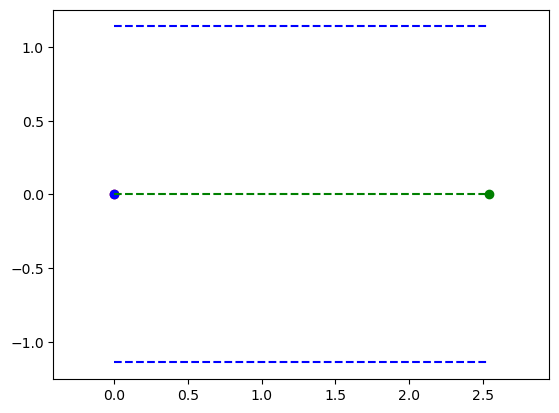

moving left!
done moving.
COMPUTING
SCORE0: [16915, 12269, 21274]
RESULT: [16915, 14722.8, 10637.0]


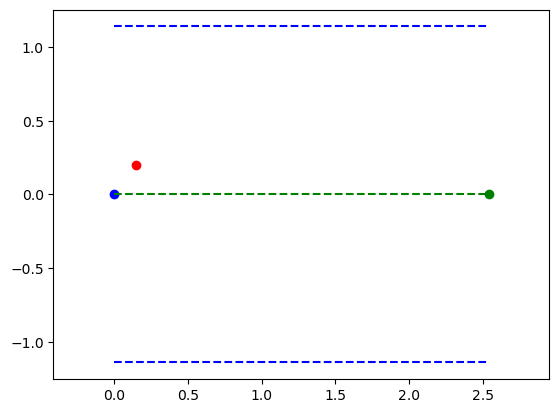

moving left!
done moving.
COMPUTING
SCORE0: [17021, 12542, 18262]
RESULT: [17021, 15050.4, 18262]


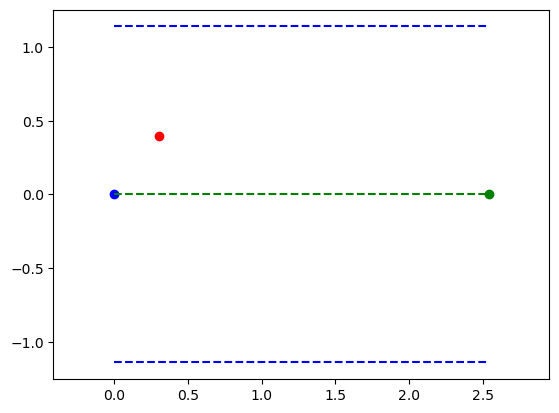

moving right!
done moving.
COMPUTING
SCORE0: [17944, 10920, 18138]
RESULT: [17944, 13104.0, 9069.0]


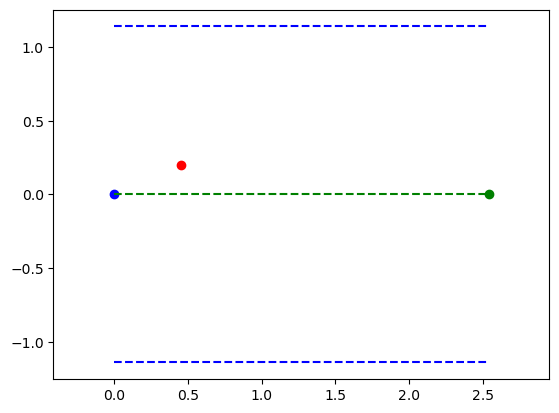

moving left!
done moving.
COMPUTING
SCORE0: [17462, 13550, 6101]
RESULT: [17462, 16260.0, 6101]


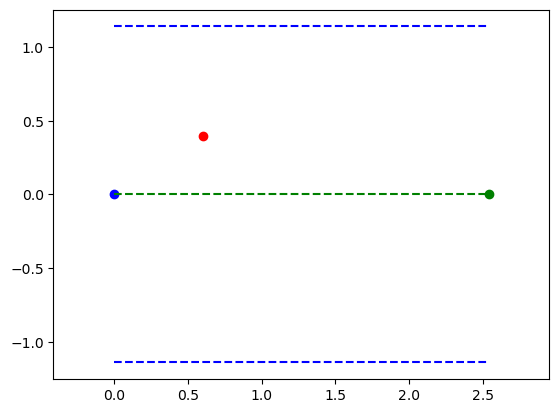

moving left!
done moving.
COMPUTING
SCORE0: [18763, 18771, 18231]
RESULT: [18763, 22525.2, 18231]


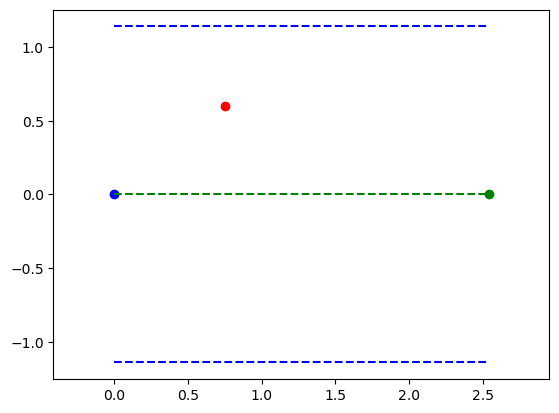

moving forward!
done moving.
COMPUTING
SCORE0: [21249, 12648, 16426]
RESULT: [21249, 15177.599999999999, 16426]


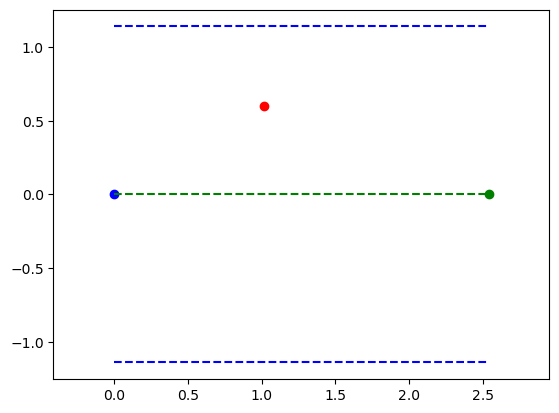

moving left!
done moving.
COMPUTING
SCORE0: [21295, 11864, 17572]
RESULT: [10647.5, 14236.8, 17572]


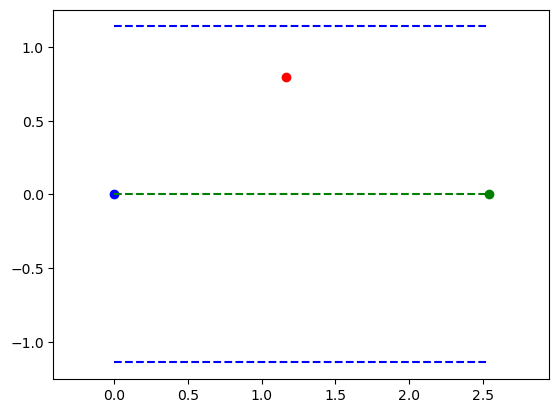

moving right!
done moving.
COMPUTING
SCORE0: [18219, 16080, 21059]
RESULT: [18219, 19296.0, 21059]


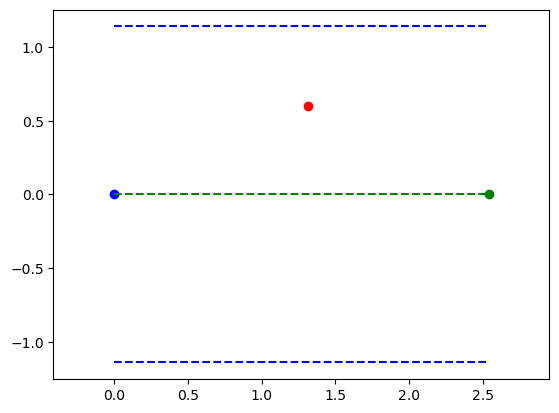

moving right!
done moving.
COMPUTING
SCORE0: [21300, 13811, 21300]
RESULT: [21300, 16573.2, 21300]


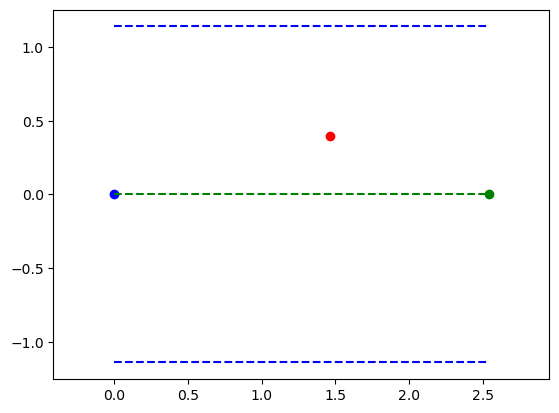

moving left!
done moving.
COMPUTING
SCORE0: [21300, 21183, 6832]
RESULT: [21300, 25419.6, 6832]


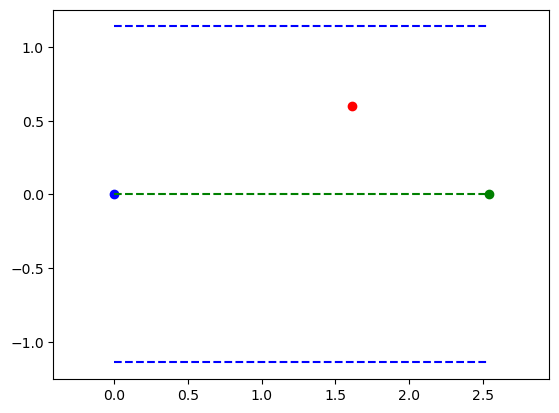

moving forward!
done moving.
COMPUTING
SCORE0: [21289, 21289, 21295]
RESULT: [21289, 25546.8, 21295]


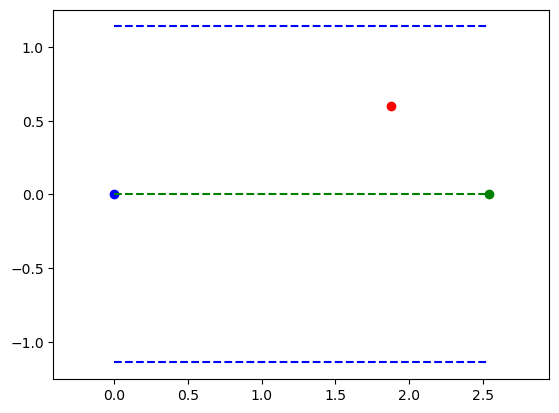

moving forward!
done moving.
COMPUTING
SCORE0: [21296, 21294, 21298]
RESULT: [21296, 25552.8, 21298]


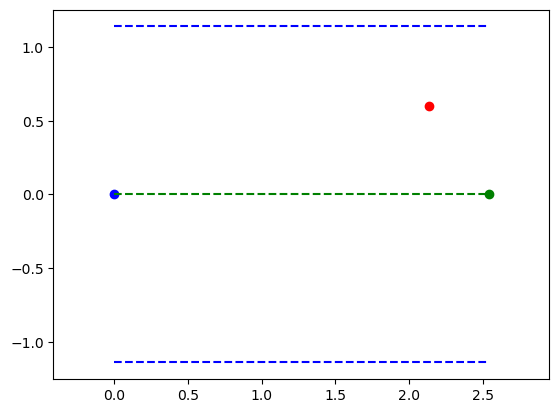

moving forward!
done moving.
COMPUTING
SCORE0: [21293, 21189, 21295]
RESULT: [21293, 25426.8, 21295]


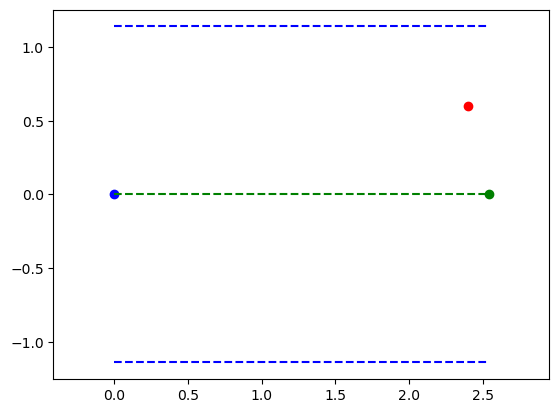

moving forward!
done moving.
landing.
elapsed:  38.98864984512329
Descending:
Done!


In [29]:
import threading

hover_setpoints = {
        OBSTACLE_DETECTING: 0.5,
        AVOIDING: 0.5,
        BOOK_FINDING: 0.8,
        BOOK_FOLLOWING: 0.8,
        None: 0.5
    }

def send_hover_command(cf, state):
    while True:
        if should_hover:
            cf.commander.send_hover_setpoint(0, 0, 0, hover_setpoints[state])
        time.sleep(0.1)


# flag
should_hover = False


# Set the URI the Crazyflie will connect to
uri = f'radio://0/{group_number}/2M'



# Initialize all the CrazyFlie drivers:
cflib.crtp.init_drivers(enable_debug_driver=False)

# Scan for Crazyflies in range of the antenna:
print('Scanning interfaces for Crazyflies...')
available = cflib.crtp.scan_interfaces()

# List local CrazyFlie devices:
print('Crazyflies found:')
for i in available:
    print(i[0])

# Check that CrazyFlie devices are available:
if len(available) == 0:
    print('No Crazyflies found, cannot run example')
else:
    ## Ascent to hover; run the sequence; then descend from hover:
    # Use the CrazyFlie corresponding to team number:
    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        # Get the Crazyflie class instance:
        cf = scf.cf

        state = OBSTACLE_DETECTING
        
        # Create hover thread
        hover_thread = threading.Thread(target=send_hover_command, args=(cf, state,))
        hover_thread.daemon = True
        hover_thread.start()
        
        current_x, current_y = 0.0, 0.0

        # Initialize and ascend:
        t = time.time()
        elapsed = time.time() - t
        ascended_bool = 0
        
        frames = []
        box = None

        cap = cv2.VideoCapture(camera)
        while(cap.isOpened()):

            ret, frame = cap.read()

            elapsed = time.time() - t
            if(elapsed > 3.0):


                if ret:
                    cv2.imshow('frame',frame)

                    if(ascended_bool==0):
                        set_PID_controller(cf)
                        ascend_and_hover(cf)
                        should_hover=True
                        ascended_bool = 1
                        x, y, yaw = 0, 0, 0
                        box = Box(x, y, yaw)
                    else:
                        pass
            if(elapsed > 8.0):

                if state == OBSTACLE_DETECTING:
                    should_hover = True
                    frames.append(frame)

                    if len(frames) >= 30:
                        print('COMPUTING')
                        # Compute the median frame
                        median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
                        frame = median_frame

                        # These define the upper and lower HSV for the red obstacles.
                        # Note that the red color wraps around 180, so there are two intervals.
                        # Tuning of these values will vary depending on the camera.
                        lb1 = (145, 35, 75)
                        ub1 = (180, 255, 255)
                        lb2 = (0, 75, 75)
                        ub2 = (20, 255, 255)

                        # Perform contour detection on the input frame.
                        hsv1 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
                        hsv2 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

                        # Compute mask of red obstacles in either color range.
                        mask1 = cv2.inRange(hsv1, lb1, ub1)
                        mask2 = cv2.inRange(hsv2, lb2, ub2)
                        # Combine the masks.
                        mask = cv2.bitwise_or(mask1, mask2)
                        mask = mask[frame.shape[0]//2-75:frame.shape[0]//2+50,:] # crop to 200 tall from center

                        # Divide the FOV into three parts: left, middle, right
                        fov_third = mask.shape[1] // 3
                        left_fov = mask[:, :fov_third]
                        middle_fov = mask[:, fov_third:2*fov_third]
                        right_fov = mask[:, 2*fov_third:]

                        direction = smart_which_way(left_fov, middle_fov, right_fov, current_x, current_y, box)
                        box.show_pos(current_x, current_y)

                        # Switch to scanning mode
                        state = AVOIDING
                        frames = []

                elif state == AVOIDING:
                    should_hover = False
                    print(f"moving {direction}!")
                    # Perform moving operations
                    if direction == 'left':
                        current_x, current_y = move_forward_and_left(cf, current_x, current_y)
                    elif direction == 'right':
                        current_x, current_y = move_forward_and_right(cf, current_x, current_y)
                    else:
                        current_x, current_y = move_forward(cf, current_x, current_y)
                    print('done moving.')
                    frames = []

                    # Switch to scanning mode
                    state = OBSTACLE_DETECTING

                elif state == BOOK_FINDING:
                    should_hover = True
                    # Perform book finding operations
                    print("finding book.")

                    frames.append(frame)

                    if len(frames) >= 30:
                        print('COMPUTING')
                        # Compute the median frame
                        median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
                        frame = median_frame

                        # These define the upper and lower HSV for the blue obstacles.
                        # Tuning of these values will vary depending on the camera.
                        lb1 = (100, 150, 75)
                        ub1 = (140, 255, 255)

                        # Perform contour detection on the input frame.
                        hsv1 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

                        # Compute mask of blue obstacles
                        mask1 = cv2.inRange(hsv1, lb1, ub1)

                        mask = mask[frame.shape[0]//2-50:frame.shape[0]//2+50,:] # crop

                        # Divide FOV into five parts
                        book_direction = which_way_book(mask)

                        box.show_pos(current_x, current_y)

                        # Switch to scanning mode
                        state = BOOK_FOLLOWING
                        frames = []


                elif state == BOOK_FOLLOWING:
                    should_hover = False
                    print(f"moving {book_direction}!")
                    # Perform moving operations
                    if book_direction == 'scoot left':
                        current_x, current_y = scoot_left(cf, current_x, current_y)
                    elif book_direction == 'scoot right':
                        current_x, current_y = scoot_right(cf, current_x, current_y)
                    elif book_direction == 'land forward':
                        current_x, current_y = land_forward(cf, current_x, current_y)
                        print("landing.")
                        break
                    else:
                        current_x, current_y, is_done = scoot_forward(cf, current_x, current_y)
                        if is_done:
                            print("landing.")
                            current_x, current_y = land_forward(cf, current_x, current_y)
                            break
                    print('done moving.')
                    frames = []

                    # Switch to scanning mode
                    state = BOOK_FINDING
                    should_hover = True
            
            if state != BOOK_FINDING and state != BOOK_FOLLOWING and box is not None and current_x > box.goal[0]:
                # move to prime book-finding position
                print("moving to prime book-finding position.")
                move_to_prime(cf, current_x, current_y, box)
                
                frames = []
                state = BOOK_FINDING
            
                # print("landing.")
                # should_hover = False
                # break

        cap.release()
        
        print('elapsed: ', elapsed)

        # Descend and stop all motion:
        hover_and_descend(cf)

print('Done!')